In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV


### EDA

Tahap 1: Mengimpor dataset. Pada tahap ini, dataset saham `ANTM.JK.csv` dimuat menggunakan `pandas`. Kolom "Date" juga diparsing menjadi format tanggal agar dapat dianalisis secara temporal di tahap selanjutnya. Selanjutnya menyortir data berdasarkan tanggal. Langkah ini menyortir data berdasarkan kolom `Date` secara ascending, untuk memastikan urutan kronologis saat melakukan analisis time series

In [2]:
df = pd.read_csv("ANTM.JK.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)

Tahap 2: Menampilkan informasi awal data. Digunakan fungsi `.info()` untuk melihat struktur dataset, seperti jumlah baris, kolom, tipe data, dan jumlah nilai non-null di setiap kolom

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3808 non-null   datetime64[ns]
 1   Open       3807 non-null   float64       
 2   High       3807 non-null   float64       
 3   Low        3807 non-null   float64       
 4   Close      3807 non-null   float64       
 5   Adj Close  3807 non-null   float64       
 6   Volume     3807 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 208.4 KB


Tahap 3: Statistik deskriptif data. Menampilkan ringkasan statistik seperti mean, standar deviasi, nilai minimum, maksimum, dan kuartil dari setiap kolom numerik

In [ ]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3808,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3.807000e+03
mean,2013-06-09 15:23:04.033613312,1207.953241,1230.793315,1185.663883,1207.159945,1047.459832,6.858102e+07
min,2005-09-29 00:00:00,290.000000,294.000000,285.000000,287.000000,280.434296,0.000000e+00
25%,2009-07-29 18:00:00,768.578796,780.000000,751.779297,765.000000,713.299744,1.420484e+07
50%,2013-06-15 12:00:00,957.573608,978.573059,945.000000,957.573608,902.836792,3.421840e+07
75%,2017-05-05 18:00:00,1595.956055,1621.155273,1570.756714,1595.956055,1347.260193,7.306722e+07
max,2021-02-03 00:00:00,4409.878418,4451.877441,4115.886719,4241.883301,3190.000000,2.186653e+09
std,NaN,664.882117,679.635933,649.243280,665.202070,495.685067,1.308133e+08


Tahap 4: Mengecek nilai yang hilang. Langkah ini penting untuk mengetahui apakah terdapat data yang hilang pada kolom-kolom dataset, yang dapat mempengaruhi kualitas analisis

In [ ]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Tahap 5: Pemeriksaan duplikasi data. Pada tahap ini dilakukan pengecekan apakah terdapat baris data yang terduplikasi dalam dataset. Duplikasi data dapat menyebabkan bias dalam analisis dan pelatihan model, sehingga penting untuk diidentifikasi dan dibersihkan jika perlu

In [4]:
df.duplicated().sum()

0

Tahap 6: Deteksi outlier. Pada tahap ini dilakukan deteksi outlier pada kolom harga penutupan (Close) menggunakan metode Interquartile Range (IQR). Outlier adalah data yang terletak jauh dari sebaran umum.

Langkah-langkah:

1. Dihitung nilai Q1 (kuartil bawah), Q3 (kuartil atas), dan IQR (Q3 - Q1).

2. Ditentukan batas bawah dan atas menggunakan rumus:
    - Lower Bound = Q1 - 1.5 * IQR
    - Upper Bound = Q3 + 1.5 * IQR

    Data yang berada di luar rentang tersebut dikategorikan sebagai outlier.

Visualisasi dilakukan menggunakan scatter plot berdasarkan waktu (Date) untuk menunjukkan persebaran harga Close dan menandai outlier dengan warna merah. Grafik menunjukan ada 4 periode dimana harga Close masuk ke bagian outlier diwaktu yang berdekatan. Dua di antaranya merupakan periode signifikan yang terjadi pada tahun 2007–2008 dan 2020, di mana harga saham menunjukkan lonjakan atau penurunan tajam yang menyebabkan data berada di luar batas wajar. Sementara itu, dua periode lainnya menunjukkan kemunculan outlier yang hanya berlangsung sesaat dan tidak berkelanjutan. Fenomena ini mengindikasikan adanya potensi kejadian ekstrem atau sentimen pasar yang kuat pada waktu-waktu tertentu

Jumlah outlier: 298


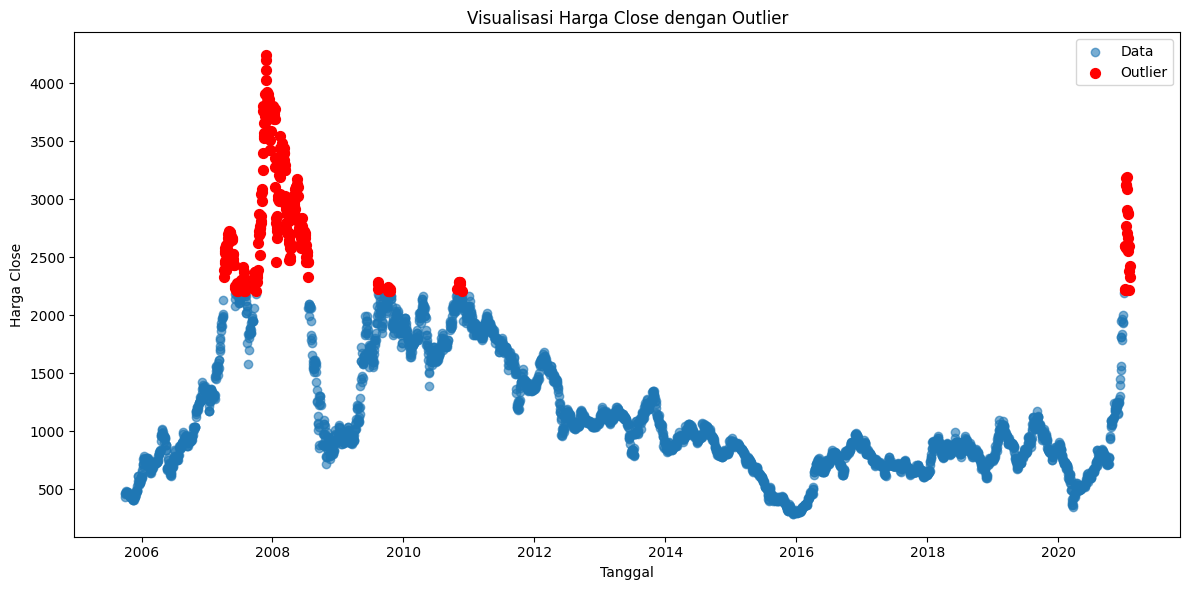

In [13]:
# Hitung Q1, Q3 dan IQR
Q1 = df["Close"].quantile(0.30)
Q3 = df["Close"].quantile(0.70)
IQR = Q3 - Q1

# Tentukan batas bawah dan atas
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Deteksi outlier
outliers = df[(df["Close"] < lower) | (df["Close"] > upper)]
print("Jumlah outlier:", outliers.shape[0])

# Visualisasi sebaran outlier
plt.figure(figsize=(12, 6))
plt.scatter(df["Date"], df["Close"], label="Data", alpha=0.6)
plt.scatter(outliers["Date"], outliers["Close"], color="red", label="Outlier", s=50)
plt.title("Visualisasi Harga Close dengan Outlier")
plt.xlabel("Tanggal")
plt.ylabel("Harga Close")
plt.legend()
plt.tight_layout()
plt.show()


Tahap 7: Visualisasi harga close seiring waktu. Grafik garis berikut menampilkan tren harga penutupan (Close) saham ANTM.JK dari waktu ke waktu. Visualisasi ini berfungsi untuk mengidentifikasi pola musiman, tren jangka panjang, dan tingkat volatilitas harga. Dari grafik dapat diamati adanya lonjakan harga yang signifikan pada periode 2006 hingga 2008, yang dipengaruhi oleh dinamika pasar global akibat krisis ekonomi saat itu. Setelah periode tersebut, harga mengalami penurunan, sebelum akhirnya kembali meningkat secara tajam pada tahun 2020, yang berkorelasi dengan dampak pandemi COVID-19 terhadap pasar komoditas dan saham tambang. Tren ini mencerminkan bagaimana kondisi ekonomi makro memengaruhi pergerakan harga saham dalam jangka panjang

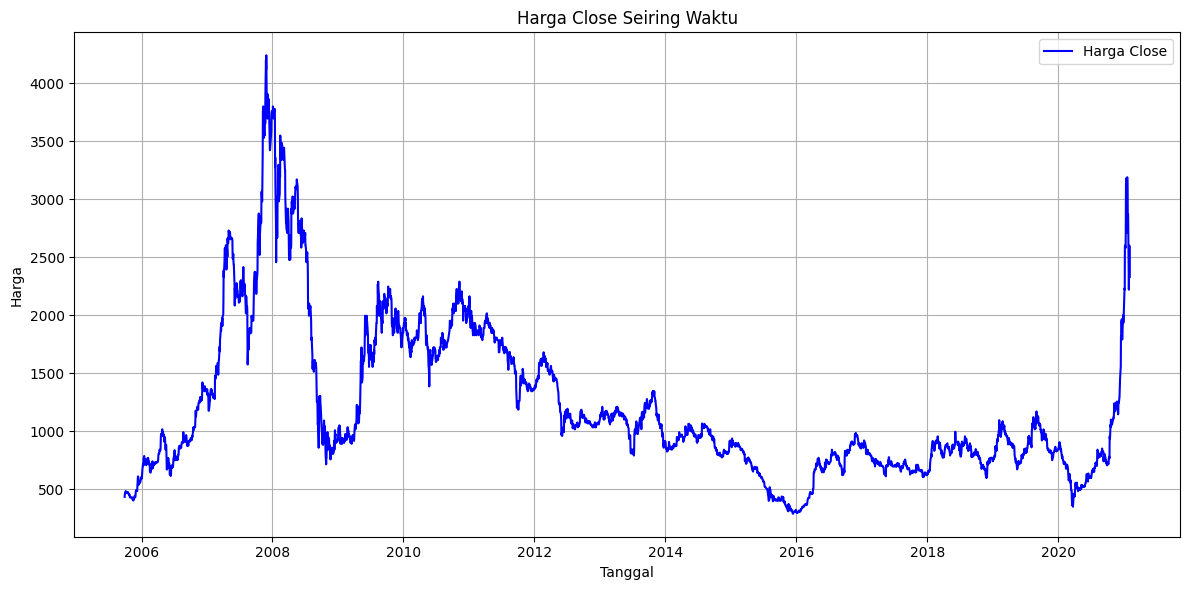

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Harga Close", color="blue")
plt.title("Harga Close Seiring Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Tahap 7: Visualisasi distribusi harga close. Distribusi harga penutupan ("Close") divisualisasikan menggunakan histogram dan KDE untuk memahami sebarann harga dalam periode yang diamati. Terlihat dari grafik, harga close paling banyak berada dikisaran 500 - 1250. Hal ini mengindikasikan bahwa selama mayoritas waktu dalam rentang data, harga saham cenderung berada pada level tersebut. Informasi ini penting untuk memahami karakteristik umum pergerakan harga dan membantu dalam analisis risiko serta pengambilan keputusan investasi

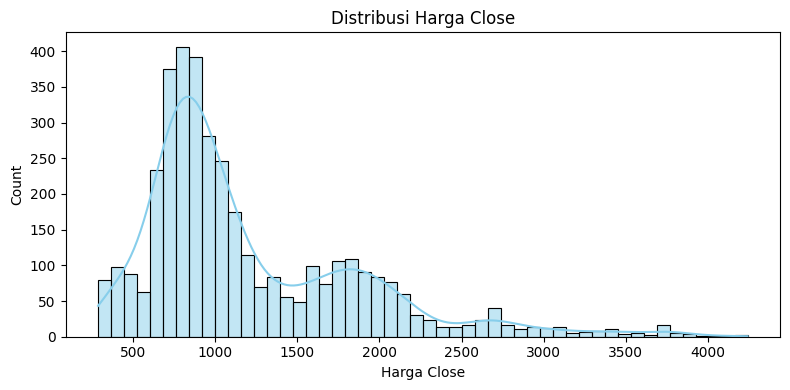

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Close"], bins=50, kde=True, color="skyblue")
plt.title("Distribusi Harga Close")
plt.xlabel("Harga Close")
plt.tight_layout()
plt.show()

Tahap 8: Visualisasi korelasi antar fitur. Matriks korelasi ditampilkan dalam bentuk heatmap untuk menunjukkan tingkat hubungan linier antar fitur numerik seperti Open, High, Low, Close, Adj Close, dan Volume. Visualisasi ini membantu dalam mengidentifikasi fitur-fitur yang saling berkaitan erat, yang penting untuk analisis multivariat maupun pemilihan fitur dalam pemodelan. Dari heatmap terlihat bahwa fitur-fitur harga (Open, High, Low, Close, dan Adj Close) memiliki korelasi sangat tinggi satu sama lain, berada di kisaran 0.98 hingga hampir 1.00, menandakan bahwa pergerakan satu harga hampir selalu diikuti oleh fitur harga lainnya. Sebaliknya, Volume menunjukkan korelasi yang rendah terhadap fitur lainnya, dengan nilai korelasi hanya berkisar antara 0.13 hingga 0.22, yang mengindikasikan bahwa jumlah transaksi tidak secara langsung sejalan dengan perubahan harga.

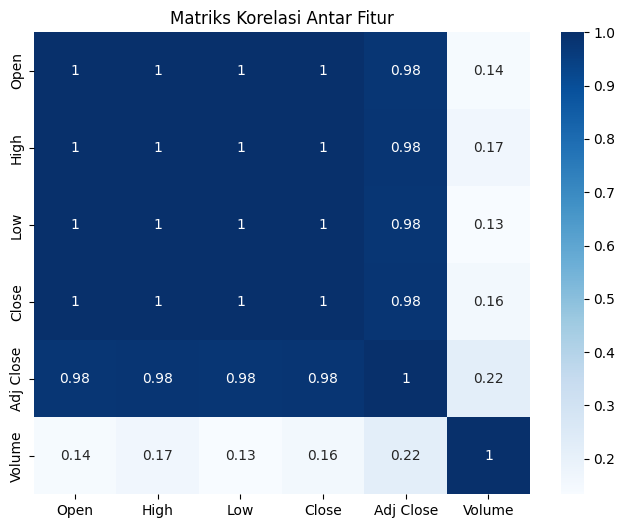

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].corr(), annot=True, cmap="Blues")
plt.title("Matriks Korelasi Antar Fitur")
plt.show()

### Preprocessing

Tahap 9: Menghapus Baris dengan Nilai Kosong. Langkah ini menghapus seluruh baris yang memiliki nilai kosong ("NaN") agar tidak mengganggu proses pelatihan model dan menjaga integritas data

In [ ]:
df.dropna(inplace=True)

Tahap 10: Seleksi fitur. Dipilih lima fitur kuantitatif utama yang berhubungan langsung dengan harga saham: `Open`, `High`, `Low`, `Close`, dan `Adj Close`. Fitur `Volume` tidak digunakan

In [ ]:
features = ["Open", "High", "Low", "Close", "Adj Close"]
data = df[features]

Tahap 11: Normalisasi data. Seluruh nilai fitur dinormalisasi ke dalam rentang [0, 1] menggunakan `MinMaxScaler` dari scikit-learn. Normalisasi diperlukan agar model pembelajaran mesin dapat memproses data secara seimbang tanpa bias terhadap fitur yang memiliki skala lebih besar

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Tahap 12: Membuat fungsi sliding window. Fungsi `window()` dibuat untuk membentuk dataset time series dengan pendekatan sliding window. Setiap sampel input (X) terdiri dari 60 hari data sebelumnya, dan target output (y) adalah harga `Close` pada hari ke-61

In [ ]:
def window(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i][3])
    return np.array(X), np.array(y)

Tahap 13: Membentuk data time series. Dengan menggunakan fungsi sliding window, data diubah menjadi format 3 dimensi untuk keperluan model seperti LSTM: (jumlah sampel, panjang window, jumlah fitur)

In [ ]:
window_size = 60
X, y = window(scaled_data, window_size)

Tahap 14: Menyesuaikan tanggal dengan window. Karena data diubah menggunakan sliding window, maka indeks tanggal juga harus disesuaikan. Tanggal baru dimulai dari titik ke-61 dan akan digunakan untuk keperluan plotting hasil prediksi.

In [ ]:
dates = df["Date"][window_size:]
dates_train, dates_test = train_test_split(dates, test_size=0.2, shuffle=False)

Tahap 15: Membagi data menjadi data latih dan data uji. Data dibagi menjadi dua bagian: 80% untuk pelatihan dan 20% untuk pengujian. Pembagian dilakukan tanpa pengacakan (`shuffle=False`) karena urutan data sangat penting dalam analisis time series.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Modeling

##### LSTM

Tahap 16: Pembangunan, pelatihan, dan evaluasi model LSTM

Pada tahap ini dilakukan serangkaian proses untuk membangun dan mengevaluasi model Long Short-Term Memory (LSTM), yang dirancang khusus untuk data time series.

- **Arsitektur Model**: Model terdiri dari dua lapisan LSTM dengan masing-masing 50 unit. Lapisan pertama mengembalikan urutan agar dapat diteruskan ke lapisan berikutnya. Lapisan terakhir adalah `Dense` untuk memproduksi output berupa prediksi harga.
- **Pelatihan Model**: Model dilatih selama 20 epoch dengan batch size 32 menggunakan fungsi loss `mean_squared_error` dan optimizer `adam`. Validasi dilakukan pada data uji.
- **Prediksi dan Inverse Transform**: Setelah pelatihan, model digunakan untuk memprediksi harga `Close`. Karena data telah dinormalisasi sebelumnya, hasil prediksi dikembalikan ke skala aslinya menggunakan `MinMaxScaler`.
- **Visualisasi Hasil**: Hasil prediksi dibandingkan dengan nilai aktual dalam bentuk grafik garis terhadap waktu, untuk melihat akurasi visual dari model.
- **Evaluasi Model**: Evaluasi dilakukan menggunakan metrik regresi:
  - MAE (Mean Absolute Error)
  - MSE (Mean Squared Error)
  - RMSE (Root Mean Squared Error)
  - R2 Score

Tujuan akhir dari tahap ini adalah mengetahui seberapa baik model LSTM dalam memprediksi harga saham berdasarkan data historis.

Epoch 1/20
94/94 [==============================] - 9s 33ms/step - loss: 0.0042 - val_loss: 7.8009e-04
Epoch 2/20
94/94 [==============================] - 2s 26ms/step - loss: 7.2194e-04 - val_loss: 6.2261e-04
Epoch 3/20
94/94 [==============================] - 2s 25ms/step - loss: 6.0959e-04 - val_loss: 5.9976e-04
Epoch 4/20
94/94 [==============================] - 2s 26ms/step - loss: 5.2569e-04 - val_loss: 5.6169e-04
Epoch 5/20
94/94 [==============================] - 2s 26ms/step - loss: 4.8457e-04 - val_loss: 4.2160e-04
Epoch 6/20
94/94 [==============================] - 2s 25ms/step - loss: 5.4375e-04 - val_loss: 3.8410e-04
Epoch 7/20
94/94 [==============================] - 2s 27ms/step - loss: 4.3109e-04 - val_loss: 3.9256e-04
Epoch 8/20
94/94 [==============================] - 2s 26ms/step - loss: 4.3079e-04 - val_loss: 3.4740e-04
Epoch 9/20
94/94 [==============================] - 2s 26ms/step - loss: 4.8016e-04 - val_loss: 3.1461e-04
Epoch 10/20
94/94 [======================

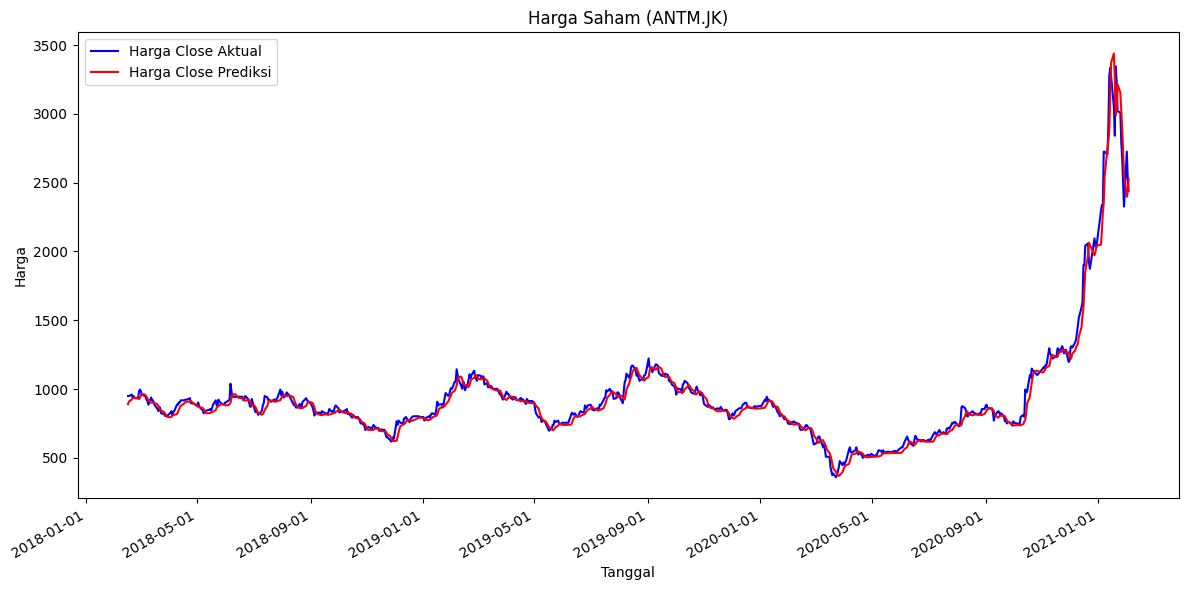

In [11]:
# Model LStM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# latih model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Lakukan prediksi
predicted = model.predict(X_test)

# Inverse transform prediksi untuk dibandingkan
full_scaler = MinMaxScaler()
full_scaler.fit(data)

# Buat array untuk hasil prediksi
y_test_full = np.zeros((y_test.shape[0], data.shape[1]))
y_test_full[:, 1] = y_test

predicted_full = np.zeros((predicted.shape[0], data.shape[1]))
predicted_full[:, 1] = predicted.reshape(-1)

# Lakukan inverse transform
y_test_rescaled = full_scaler.inverse_transform(y_test_full)[:, 1]
predicted_rescaled = full_scaler.inverse_transform(predicted_full)[:, 1]

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_rescaled, color="blue", label="Harga Close Aktual")
plt.plot(dates_test, predicted_rescaled, color="red", label="Harga Close Prediksi")
plt.title("Harga Saham (ANTM.JK)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Evaluasi
lstm_mae = mean_absolute_error(y_test_rescaled, predicted_rescaled)
lstm_mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test_rescaled, predicted_rescaled)

##### GRU

Tahap 17: Pembangunan, pelatihan, dan evaluasi model GRU

Pada tahap ini dilakukan proses serupa seperti LSTM, namun menggunakan model **Gated Recurrent Unit (GRU)**. GRU merupakan alternatif dari LSTM dengan struktur yang lebih sederhana dan efisien, namun tetap efektif dalam mempelajari pola dari data time series.

- **Arsitektur Model**: Model GRU terdiri dari dua lapisan GRU dengan masing-masing 50 unit. Lapisan pertama mengembalikan urutan (return_sequences=True) untuk diteruskan ke lapisan kedua. Lapisan terakhir berupa `Dense` untuk menghasilkan satu nilai prediksi.
- **Pelatihan Model**: Dilatih selama 20 epoch dengan batch size 32 menggunakan `adam` optimizer dan fungsi loss `mean_squared_error`.
- **Prediksi dan Inverse Transform**: Setelah pelatihan, dilakukan prediksi pada data uji. Hasil prediksi dikembalikan ke skala harga sebenarnya menggunakan kembali `MinMaxScaler`.
- **Visualisasi Hasil**: Dibandingkan antara harga aktual dan harga prediksi untuk menilai performa model secara visual.
- **Evaluasi Model**: Kinerja model dievaluasi dengan metrik:
  - MAE (Mean Absolute Error)
  - MSE (Mean Squared Error)
  - RMSE (Root Mean Squared Error)
  - R2 Score

Tujuan dari tahap ini adalah mengevaluasi apakah model GRU dapat menjadi alternatif yang kompetitif dalam memprediksi harga saham berdasarkan pola historis.


Epoch 1/20
94/94 [==============================] - 7s 34ms/step - loss: 0.0028 - val_loss: 3.1146e-04
Epoch 2/20
94/94 [==============================] - 2s 26ms/step - loss: 3.3481e-04 - val_loss: 2.6399e-04
Epoch 3/20
94/94 [==============================] - 2s 24ms/step - loss: 2.8355e-04 - val_loss: 2.2866e-04
Epoch 4/20
94/94 [==============================] - 2s 26ms/step - loss: 2.7242e-04 - val_loss: 2.1419e-04
Epoch 5/20
94/94 [==============================] - 2s 25ms/step - loss: 2.3669e-04 - val_loss: 2.0135e-04
Epoch 6/20
94/94 [==============================] - 2s 25ms/step - loss: 2.1444e-04 - val_loss: 1.8229e-04
Epoch 7/20
94/94 [==============================] - 2s 25ms/step - loss: 2.0827e-04 - val_loss: 1.7792e-04
Epoch 8/20
94/94 [==============================] - 2s 25ms/step - loss: 2.0601e-04 - val_loss: 1.7300e-04
Epoch 9/20
94/94 [==============================] - 2s 25ms/step - loss: 2.1263e-04 - val_loss: 1.6346e-04
Epoch 10/20
94/94 [======================

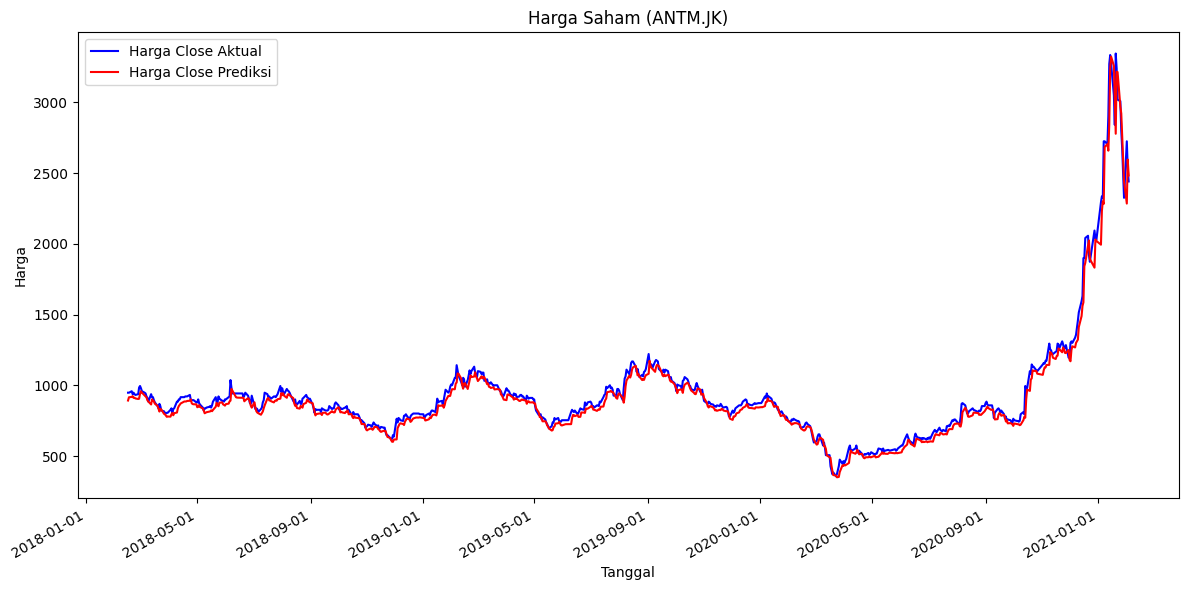

In [12]:
# Model GRU
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Latih model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Lakukan prediksi
predicted = model.predict(X_test)

# Inverse transform prediksi untuk dibandingkan
full_scaler = MinMaxScaler()
full_scaler.fit(data)

# Buat array untuk hasil prediksi
y_test_full = np.zeros((y_test.shape[0], data.shape[1]))
y_test_full[:, 1] = y_test

predicted_full = np.zeros((predicted.shape[0], data.shape[1]))
predicted_full[:, 1] = predicted.reshape(-1)

# Lakukan inverse transform
y_test_rescaled = full_scaler.inverse_transform(y_test_full)[:, 1]
predicted_rescaled = full_scaler.inverse_transform(predicted_full)[:, 1]

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_rescaled, color="blue", label="Harga Close Aktual")
plt.plot(dates_test, predicted_rescaled, color="red", label="Harga Close Prediksi")
plt.title("Harga Saham (ANTM.JK)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Evaluasi
gru_mae = mean_absolute_error(y_test_rescaled, predicted_rescaled)
gru_mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(y_test_rescaled, predicted_rescaled)


#### Hyperparameter Tuning

Tahap 18: Pembuatan Fungsi Model dan Penyiapan Hyperparameter Tuning

Pada tahap ini, dibuat fungsi untuk mendefinisikan arsitektur model **LSTM** dan **GRU** agar dapat digunakan bersama dengan `KerasRegressor`. Hal ini memudahkan dalam melakukan **hyperparameter tuning** menggunakan `GridSearchCV`.

Penjelasan Proses:
- **Fungsi `lstm_model` dan `gru_model`**:
  - Menerima parameter `units` dan `optimizer` untuk fleksibilitas tuning.
  - Arsitektur terdiri dari dua layer LSTM atau GRU dan satu output `Dense`.
  - Kompilasi model menggunakan `mean_squared_error` sebagai fungsi loss, sesuai untuk regresi.
  - GRU model menambahkan metrik `mae` untuk evaluasi tambahan.

- **KerasRegressor**:
  - `KerasRegressor` membungkus fungsi model agar bisa digunakan seperti model scikit-learn.
  - Parameter tuning dilakukan dengan `verbose=1` untuk menampilkan progres pelatihan.

- **Grid Search Setup**:
  - Didefinisikan dictionary `param_grid` untuk eksplorasi beberapa kombinasi parameter:
    - `units`: Jumlah unit pada masing-masing layer (32, 50, 64).
    - `batch_size`: Ukuran batch pelatihan (16, 32).
    - `epochs`: Jumlah epoch (10, 20).
    - `optimizer`: Optimizer yang digunakan (`adam`, `rmsprop`).
    
Grid Search ini memungkinkan pencarian konfigurasi model yang paling optimal berdasarkan performa validasi.


In [ ]:
# Model LSTM
def lstm_model(units=50, optimizer="adam"):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

lstm_reg = KerasRegressor(build_fn=lstm_model, verbose=1)

# Model GRU
def gru_model(units=50, optimizer="adam"):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(units=units))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])
    return model

gru_reg = KerasRegressor(build_fn=gru_model, verbose=1)

# Parameter untuk di lakukan tuning
param_grid = {
    "units": [32, 50, 64],
    "batch_size": [16, 32],
    "epochs": [10, 20],
    "optimizer": ["adam", "rmsprop"]
}


C:\Users\Sev\AppData\Local\Temp\ipykernel_5844\1331451075.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_reg = KerasRegressor(build_fn=lstm_model, verbose=1)
C:\Users\Sev\AppData\Local\Temp\ipykernel_5844\1331451075.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_reg = KerasRegressor(build_fn=gru_model, verbose=1)


##### LSTM

Tahap 19: Hyperparameter tuning model LSTM menggunakan Randomized Search

Pada tahap ini dilakukan pencarian kombinasi hyperparameter terbaik untuk model LSTM menggunakan **RandomizedSearchCV** dari scikit-learn.

Penjelasan Proses:
- **RandomizedSearchCV**:
  - Berbeda dengan `GridSearchCV` yang mencoba semua kombinasi, `RandomizedSearchCV` memilih sejumlah kombinasi parameter secara acak berdasarkan distribusi yang diberikan. Hal ini mempercepat proses pencarian, terutama jika ruang pencarian besar.
  - Parameter yang digunakan:
    - `estimator`: Objek `KerasRegressor` berbasis model LSTM.
    - `param_distributions`: Dictionary `param_grid` berisi kombinasi parameter yang akan diuji.
    - `n_iter=5`: Hanya mencoba 5 kombinasi acak dari grid parameter.
    - `cv=3`: Melakukan cross-validation sebanyak 3 fold untuk mengevaluasi setiap kombinasi.
    - `random_state=42`: Untuk memastikan hasil acak yang konsisten.

- **Hasil Akhir**:
  - Setelah proses tuning, `best_params_` akan menampilkan kombinasi parameter yang menghasilkan performa terbaik berdasarkan hasil validasi silang.

Langkah ini sangat penting untuk memastikan model LSTM bekerja secara optimal tanpa melakukan eksplorasi parameter secara manual.

In [14]:
# Random Search LSTM
random_search = RandomizedSearchCV(estimator=lstm_reg, param_distributions=param_grid, n_iter=5, cv=3, random_state=42)
random_search_result = random_search.fit(X_train, y_train)
print("Parameter terbaik dari Random Search:", random_search_result.best_params_)

Epoch 1/20
125/125 [==============================] - 6s 23ms/step - loss: 0.0011
Epoch 2/20
125/125 [==============================] - 3s 23ms/step - loss: 1.9443e-04
Epoch 3/20
125/125 [==============================] - 3s 23ms/step - loss: 1.7306e-04
Epoch 4/20
125/125 [==============================] - 3s 23ms/step - loss: 1.6778e-04
Epoch 5/20
125/125 [==============================] - 3s 23ms/step - loss: 1.4329e-04
Epoch 6/20
125/125 [==============================] - 3s 23ms/step - loss: 1.2099e-04
Epoch 7/20
125/125 [==============================] - 3s 23ms/step - loss: 1.2279e-04
Epoch 8/20
125/125 [==============================] - 3s 23ms/step - loss: 1.3008e-04
Epoch 9/20
125/125 [==============================] - 3s 23ms/step - loss: 1.1124e-04
Epoch 10/20
125/125 [==============================] - 3s 23ms/step - loss: 1.0255e-04
Epoch 11/20
125/125 [==============================] - 3s 23ms/step - loss: 1.1417e-04
Epoch 12/20
125/125 [==============================] - 3

Tahap 20: Pelatihan Ulang dan Evaluasi Model LSTM dengan Parameter Terbaik dari Randomized Search

Setelah mendapatkan parameter terbaik dari hasil tuning, tahap ini meliputi:

- **Membangun ulang model LSTM** menggunakan parameter terbaik seperti jumlah unit dan optimizer.
- **Melatih model** kembali dengan jumlah epoch dan batch size sesuai hasil tuning.
- **Melakukan prediksi** harga saham pada data uji.
- **Inverse transform** hasil prediksi dan nilai aktual ke skala harga asli agar dapat dibandingkan secara langsung.
- **Visualisasi** hasil prediksi versus harga aktual dalam grafik time series untuk analisis performa secara visual.
- **Evaluasi model** menggunakan metrik regresi (MAE, MSE, RMSE, R2) untuk kuantifikasi akurasi prediksi.

Langkah ini memastikan model menggunakan konfigurasi hyperparameter terbaik yang ditemukan dan mengevaluasi performanya secara menyeluruh.


Epoch 1/20
188/188 [==============================] - 9s 30ms/step - loss: 0.0030 - val_loss: 8.0244e-04
Epoch 2/20
188/188 [==============================] - 5s 25ms/step - loss: 6.4437e-04 - val_loss: 4.9119e-04
Epoch 3/20
188/188 [==============================] - 5s 25ms/step - loss: 5.1498e-04 - val_loss: 3.8666e-04
Epoch 4/20
188/188 [==============================] - 5s 25ms/step - loss: 5.0896e-04 - val_loss: 3.5005e-04
Epoch 5/20
188/188 [==============================] - 5s 24ms/step - loss: 4.3535e-04 - val_loss: 2.7353e-04
Epoch 6/20
188/188 [==============================] - 5s 25ms/step - loss: 4.0679e-04 - val_loss: 3.6270e-04
Epoch 7/20
188/188 [==============================] - 5s 24ms/step - loss: 3.3773e-04 - val_loss: 2.1722e-04
Epoch 8/20
188/188 [==============================] - 5s 25ms/step - loss: 2.8290e-04 - val_loss: 1.9994e-04
Epoch 9/20
188/188 [==============================] - 5s 25ms/step - loss: 2.5837e-04 - val_loss: 2.0766e-04
Epoch 10/20
188/188 [==

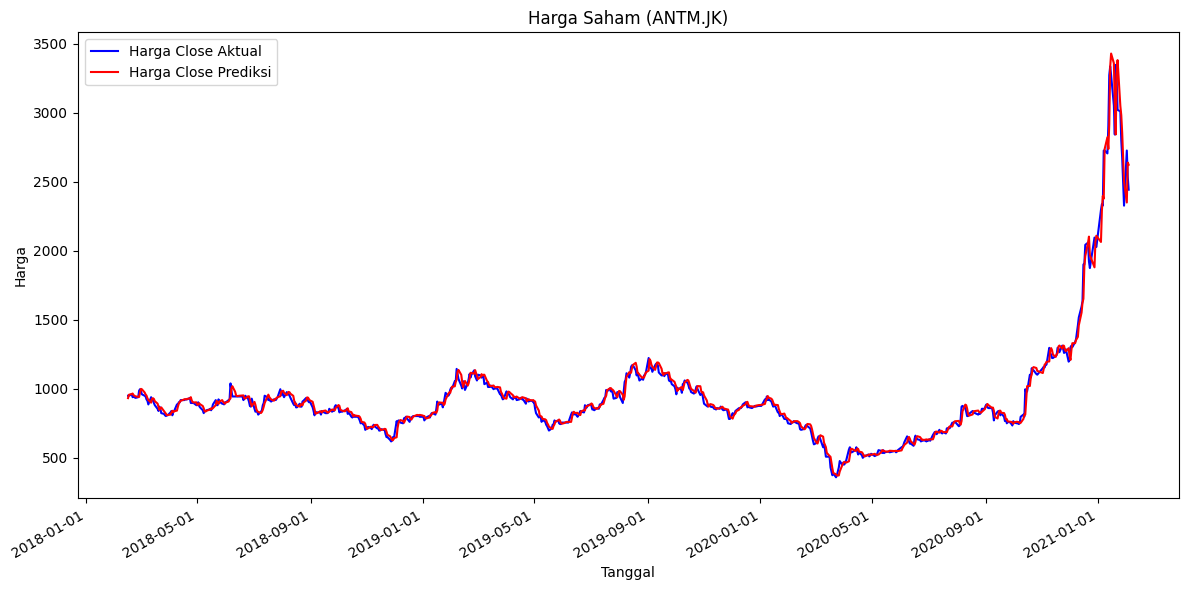

In [ ]:
# Simpan parameter terbaik
best_model = lstm_model(
    units=random_search_result.best_params_["units"],
    optimizer=random_search_result.best_params_["optimizer"],
)

# Latih model dengan parameter sebelumnya
history = best_model.fit(
    X_train, y_train, 
    epochs=random_search_result.best_params_["epochs"], 
    batch_size=random_search_result.best_params_["batch_size"], 
    validation_data=(X_test, y_test)
)

# Lakukan prediksi
predicted = best_model.predict(X_test)

# Inverse transform prediksi untuk dibandingkan
full_scaler = MinMaxScaler()
full_scaler.fit(data)

# Buat array untuk hasil prediksi
y_test_full = np.zeros((y_test.shape[0], data.shape[1]))
y_test_full[:, 1] = y_test

predicted_full = np.zeros((predicted.shape[0], data.shape[1]))
predicted_full[:, 1] = predicted.reshape(-1)

# Lakukan inverse transform
y_test_rescaled = full_scaler.inverse_transform(y_test_full)[:, 1]
predicted_rescaled = full_scaler.inverse_transform(predicted_full)[:, 1]

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_rescaled, color="blue", label="Harga Close Aktual")
plt.plot(dates_test, predicted_rescaled, color="red", label="Harga Close Prediksi")
plt.title("Harga Saham (ANTM.JK)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Evaluasi
lstm_mae_rs = mean_absolute_error(y_test_rescaled, predicted_rescaled)
lstm_mse_rs = mean_squared_error(y_test_rescaled, predicted_rescaled)
lstm_rmse_rs = np.sqrt(lstm_mse_rs)
lstm_r2_rs = r2_score(y_test_rescaled, predicted_rescaled)

##### GRU

Tahap 21: Hyperparameter Tuning Model GRU Menggunakan Randomized Search

Pada tahap ini dilakukan pencarian parameter terbaik untuk model GRU menggunakan `RandomizedSearchCV` yang menguji kombinasi parameter secara acak.

Penjelasan proses:
- `estimator`: Model GRU yang dibungkus dengan `KerasRegressor`.
- `param_distributions`: Dictionary parameter `param_grid` yang berisi nilai-nilai kandidat.
- `n_iter=5`: Mengeksekusi 5 kombinasi parameter acak.
- `cv=3`: Melakukan validasi silang sebanyak 3 kali untuk setiap kombinasi.
- `random_state=42`: Supaya hasil pencarian dapat direproduksi.

Proses ini membantu menemukan konfigurasi terbaik untuk arsitektur dan pelatihan model GRU tanpa harus mencoba semua kemungkinan secara manual.


In [16]:
# Random Search GRU
random_search = RandomizedSearchCV(estimator=gru_reg, param_distributions=param_grid, n_iter=5, cv=3, random_state=42)
random_search_result = random_search.fit(X_train, y_train)
print("Parameter terbaik dari Random Search:", random_search_result.best_params_)

Epoch 1/20
125/125 [==============================] - 6s 21ms/step - loss: 0.0019 - mae: 0.0216
Epoch 2/20
125/125 [==============================] - 3s 23ms/step - loss: 9.5417e-05 - mae: 0.0069
Epoch 3/20
125/125 [==============================] - 3s 22ms/step - loss: 8.8835e-05 - mae: 0.0067
Epoch 4/20
125/125 [==============================] - 3s 21ms/step - loss: 8.3415e-05 - mae: 0.0065
Epoch 5/20
125/125 [==============================] - 3s 22ms/step - loss: 7.3868e-05 - mae: 0.0060
Epoch 6/20
125/125 [==============================] - 3s 22ms/step - loss: 7.8133e-05 - mae: 0.0062
Epoch 7/20
125/125 [==============================] - 3s 22ms/step - loss: 6.5365e-05 - mae: 0.0056
Epoch 8/20
125/125 [==============================] - 3s 22ms/step - loss: 6.6005e-05 - mae: 0.0058
Epoch 9/20
125/125 [==============================] - 3s 22ms/step - loss: 6.5335e-05 - mae: 0.0056
Epoch 10/20
125/125 [==============================] - 3s 22ms/step - loss: 6.4289e-05 - mae: 0.0057
Epo

Tahap 22: Pelatihan ulang dan evaluasi model GRU dengan parameter terbaik dari Randomized Search

Setelah mendapatkan parameter terbaik dari tuning, dilakukan langkah berikut:

- **Membangun ulang model GRU** dengan jumlah unit dan optimizer sesuai parameter hasil tuning.
- **Melatih model kembali** menggunakan epoch dan batch size yang optimal.
- **Melakukan prediksi** pada data uji.
- **Inverse transform** prediksi dan data aktual agar dapat dibandingkan dalam skala asli harga saham.
- **Visualisasi** hasil prediksi dan harga aktual pada grafik time series.
- **Evaluasi** performa menggunakan metrik MAE, MSE, RMSE, dan R2 sebagai ukuran akurasi prediksi.

Langkah ini memastikan model GRU memakai konfigurasi hyperparameter terbaik dan memberikan gambaran performa yang jelas.


Epoch 1/20
188/188 [==============================] - 9s 29ms/step - loss: 0.0013 - mae: 0.0193 - val_loss: 2.8182e-04 - val_mae: 0.0099
Epoch 2/20
188/188 [==============================] - 5s 25ms/step - loss: 2.9573e-04 - mae: 0.0110 - val_loss: 3.2162e-04 - val_mae: 0.0126
Epoch 3/20
188/188 [==============================] - 5s 25ms/step - loss: 2.5776e-04 - mae: 0.0102 - val_loss: 3.1031e-04 - val_mae: 0.0124
Epoch 4/20
188/188 [==============================] - 5s 24ms/step - loss: 2.1901e-04 - mae: 0.0094 - val_loss: 2.2164e-04 - val_mae: 0.0090
Epoch 5/20
188/188 [==============================] - 5s 25ms/step - loss: 2.2349e-04 - mae: 0.0096 - val_loss: 1.9354e-04 - val_mae: 0.0080
Epoch 6/20
188/188 [==============================] - 4s 24ms/step - loss: 2.3156e-04 - mae: 0.0100 - val_loss: 1.8733e-04 - val_mae: 0.0080
Epoch 7/20
188/188 [==============================] - 5s 25ms/step - loss: 2.1026e-04 - mae: 0.0092 - val_loss: 1.6128e-04 - val_mae: 0.0077
Epoch 8/20
188/18

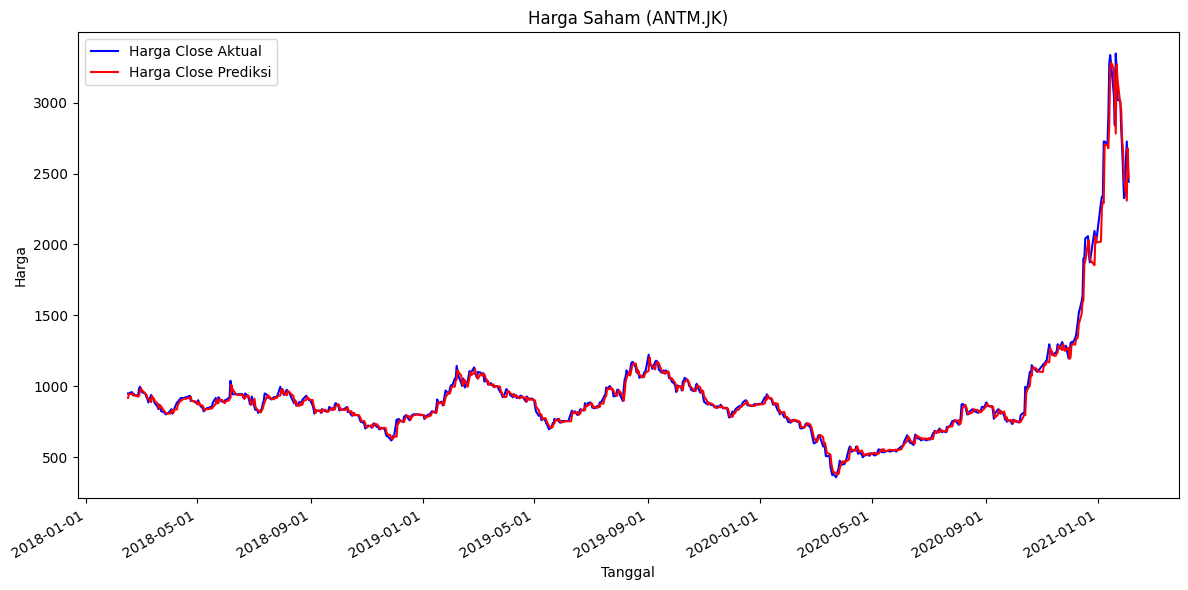

In [ ]:
# Simpan parameter terbaik
best_model = gru_model(
    units=random_search_result.best_params_["units"],
    optimizer=random_search_result.best_params_["optimizer"]
)

# Latih model dengan parameter sebelumnya
history = best_model.fit(
    X_train, y_train, 
    epochs=random_search_result.best_params_["epochs"], 
    batch_size=random_search_result.best_params_["batch_size"], 
    validation_data=(X_test, y_test)
)

# Lakukan prediksi
predicted = best_model.predict(X_test)

# Inverse transform prediksi untuk dibandingkan
full_scaler = MinMaxScaler()
full_scaler.fit(data)

# Buat array untuk hasil prediksi
y_test_full = np.zeros((y_test.shape[0], data.shape[1]))
y_test_full[:, 1] = y_test

predicted_full = np.zeros((predicted.shape[0], data.shape[1]))
predicted_full[:, 1] = predicted.reshape(-1)

# Lakukan inverse transform
y_test_rescaled = full_scaler.inverse_transform(y_test_full)[:, 1]
predicted_rescaled = full_scaler.inverse_transform(predicted_full)[:, 1]

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_rescaled, color="blue", label="Harga Close Aktual")
plt.plot(dates_test, predicted_rescaled, color="red", label="Harga Close Prediksi")
plt.title("Harga Saham (ANTM.JK)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Evaluasi
gru_mae_rs = mean_absolute_error(y_test_rescaled, predicted_rescaled)
gru_mse_rs = mean_squared_error(y_test_rescaled, predicted_rescaled)
gru_rmse_rs = np.sqrt(gru_mse_rs)
gru_r2_rs = r2_score(y_test_rescaled, predicted_rescaled)

### Evaluasi

Tahap 23: Perbandingan hasil evaluasi model LSTM dan GRU

Pada tahap ini, dilakukan perbandingan hasil metrik evaluasi utama dari keempat skenario model, yaitu:

1. Model LSTM standar tanpa tuning parameter.
2. Model LSTM dengan parameter terbaik hasil Randomized Search.
3. Model GRU standar tanpa tuning parameter.
4. Model GRU dengan parameter terbaik hasil Randomized Search.

Metrik evaluasi yang diprint meliputi:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R2 Score

Perbandingan ini membantu menentukan model dan konfigurasi mana yang memberikan hasil prediksi terbaik untuk harga saham ANTM.JK.


In [18]:
# Print hasil evaluasi semuanya
print("Evaluasi LSTM:")
print(f"Mean Absolute Error (MAE): {lstm_mae:.2f}")
print(f"Mean Squared Error (MSE): {lstm_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.2f}")
print(f"R2 Score: {lstm_r2:.4f}")

print("\nEvaluasi LSTM (Random Search):")
print(f"Mean Absolute Error (MAE): {lstm_mae_rs:.2f}")
print(f"Mean Squared Error (MSE): {lstm_mse_rs:.2f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse_rs:.2f}")
print(f"R2 Score: {lstm_r2_rs:.4f}")

print("\nEvaluasi GRU:")
print(f"Mean Absolute Error (MAE): {gru_mae:.2f}")
print(f"Mean Squared Error (MSE): {gru_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {gru_rmse:.2f}")
print(f"R2 Score: {gru_r2:.4f}")

print("\nEvaluasi GRU (Random Search):")
print(f"Mean Absolute Error (MAE): {gru_mae_rs:.2f}")
print(f"Mean Squared Error (MSE): {gru_mse_rs:.2f}")
print(f"Root Mean Squared Error (RMSE): {gru_rmse_rs:.2f}")
print(f"R2 Score: {gru_r2_rs:.4f}")

Evaluasi LSTM:
Mean Absolute Error (MAE): 35.05
Mean Squared Error (MSE): 3576.83
Root Mean Squared Error (RMSE): 59.81
R2 Score: 0.9776

Evaluasi LSTM (Random Search):
Mean Absolute Error (MAE): 27.62
Mean Squared Error (MSE): 2658.00
Root Mean Squared Error (RMSE): 51.56
R2 Score: 0.9833

Evaluasi GRU:
Mean Absolute Error (MAE): 36.85
Mean Squared Error (MSE): 3475.47
Root Mean Squared Error (RMSE): 58.95
R2 Score: 0.9782

Evaluasi GRU (Random Search):
Mean Absolute Error (MAE): 24.34
Mean Squared Error (MSE): 2534.96
Root Mean Squared Error (RMSE): 50.35
R2 Score: 0.9841
